#  Maximum likelihood estimate on cancer stem cell proliferation and differentiation rate


In this notebook, I implemented the two models derived in the main text. The goal is to infer model parameters (e.g. proliferation and differentiation rate of cancer stem cells/tumor initiating cells (TICs) and the division rate of differentiated cells (DC)), depending on the model under consideration. Below is a brief description and a schematic of the two models studied.


### Model 1

To construct the models, we'll need to specify a few things: 

 * *model_type = I* 
 * *model_para = {pvec, N0, T, Nexp}*: 
    * *pvec* : $\mathbf{p}=(p_0, p_1,p_2)$, where $p_0$ is the probability of death, $p_1$ of self-renewal, and $p_2$ is of symmetric division, all of TICs. 
    * *N1* : Number of TICs at $t=0$
    * *T* : Generations. Simulations runs from  $t=0,1,\cdots, T$
    * *Nexp* : Number of observations at each time point $t$
 
In this simulation class, at the end of each cell cycle, DCs die with probability 1 without producing any progenies. TIC, on the other hand, either dies with probability $p_0$, or self-renews to produce tww TICs with probability $p_1$, or differentiates into two DCs with probability $p_2$.


### Model 2
 * *model_type = II* 
 * *model_para = {pvec, N0, T, Nexp}*: 
    * *pvec* : $\mathbf{p}=(p, \lambda, q)$, where $1-p$ is the probability of death, $p(1-\lambda)$ of self-renewal, and $p\lambda$ is of asymmetric division, all of TICs. $q$ is the survival probability of DCs.
    * *N1* : Number of TICs at $t=0$
    * *T* : Geenerations. Simulations runs from  $t=0,1,\cdots, T$
    * *Nexp* : Number of observations at each time point $t$






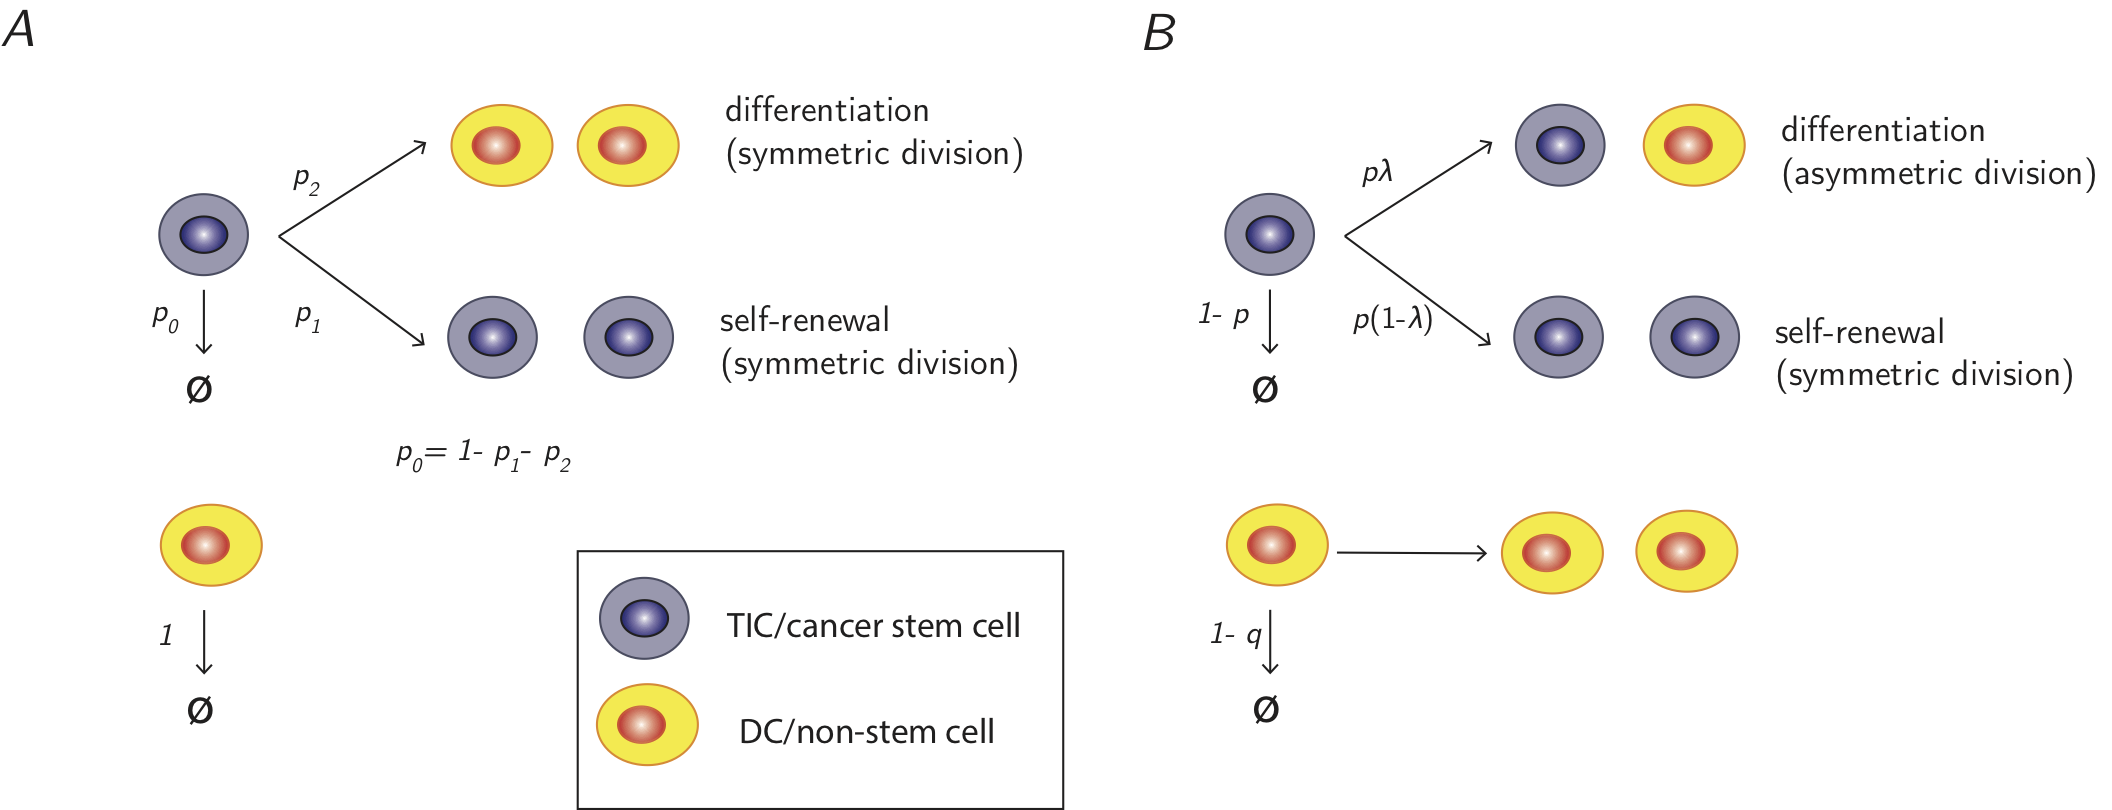

In [5]:
from IPython.display import Image
fig = Image(filename=('/Users/chinghao/Dropbox/CHW/Bayesian-TICinfer/notebooks/model-schematic-eps-converted-to.png'))
fig

## Data to do MLE on:

Cconsider an experiment consisting of $n$ measurements on the TIC fraction on different cell cultures labeled by $k=1,2,\cdots, n$. Culture $k$ started out with $N_k$ TICs and nothing else. It is then taken out to measure its TIC fraction at time $t_k$ denoted as $\Delta_1(t_k, N_k)$ (see Figure below). Note that we assume $t_1 < t_2 <\cdots < t_n$. The asymptotic normality of the relative frequency implies that as long as the initial TIC counts are large in the sense that $\min (N_0,\cdots, N_n)\gg 1$ and the cell number variance is bounded, $\sigma_i^2(t)< \infty$, the asymptotic likelihood of $\mathcal{D} = \{\Delta_1(t_k, N_k)\}_{k=1}^n$, $L_n(\mathcal{D}|p_1,p_2)$, is given by


\begin{eqnarray}\label{eq:exp_lhd}
L_n(\mathcal{D}|p_1,p_2) &=& -\frac{n}{2}\log 2\pi -\frac{1}{2}\sum_{k=1}^n \log S^2(t_k; N_k)-\frac{1}{2}\sum_{k=1}^n[\Delta_1(t_k, N_k)-p_1(t_k)]^2/S^2(t_k; N_k),
\end{eqnarray}
where $p(t_k) = m_{11}(t_k)/M(t_k)$, $M(t_k) = m_{11}(t_k) + m_{12}(t_k)$. 

The expression $S_1^2$ is given by
\begin{eqnarray}
S_1^2(t_k; N_k) &=&\frac{1}{N_k M^2(t_k)}\{\sigma_1^2(t_k)[1-p_1(t_k)]^2+\sigma_2^2(t_k)p_1^2(t_k) - 2\Sigma_{12}(t_k)p_1(t_k)[1-p_1(t_k)]\},
\end{eqnarray}
where $\sigma_i^2(t_k) = b^1_{ii}(t_k)+ m_{ii}(t_k)-m_{ii}^2(t_k)$ and ${\Sigma}_{12}(t_k) = b^1_{12}(t) - m_{11}(t_k)m_{12}(t_k)$.

The quantities are explicitly derived in my note.

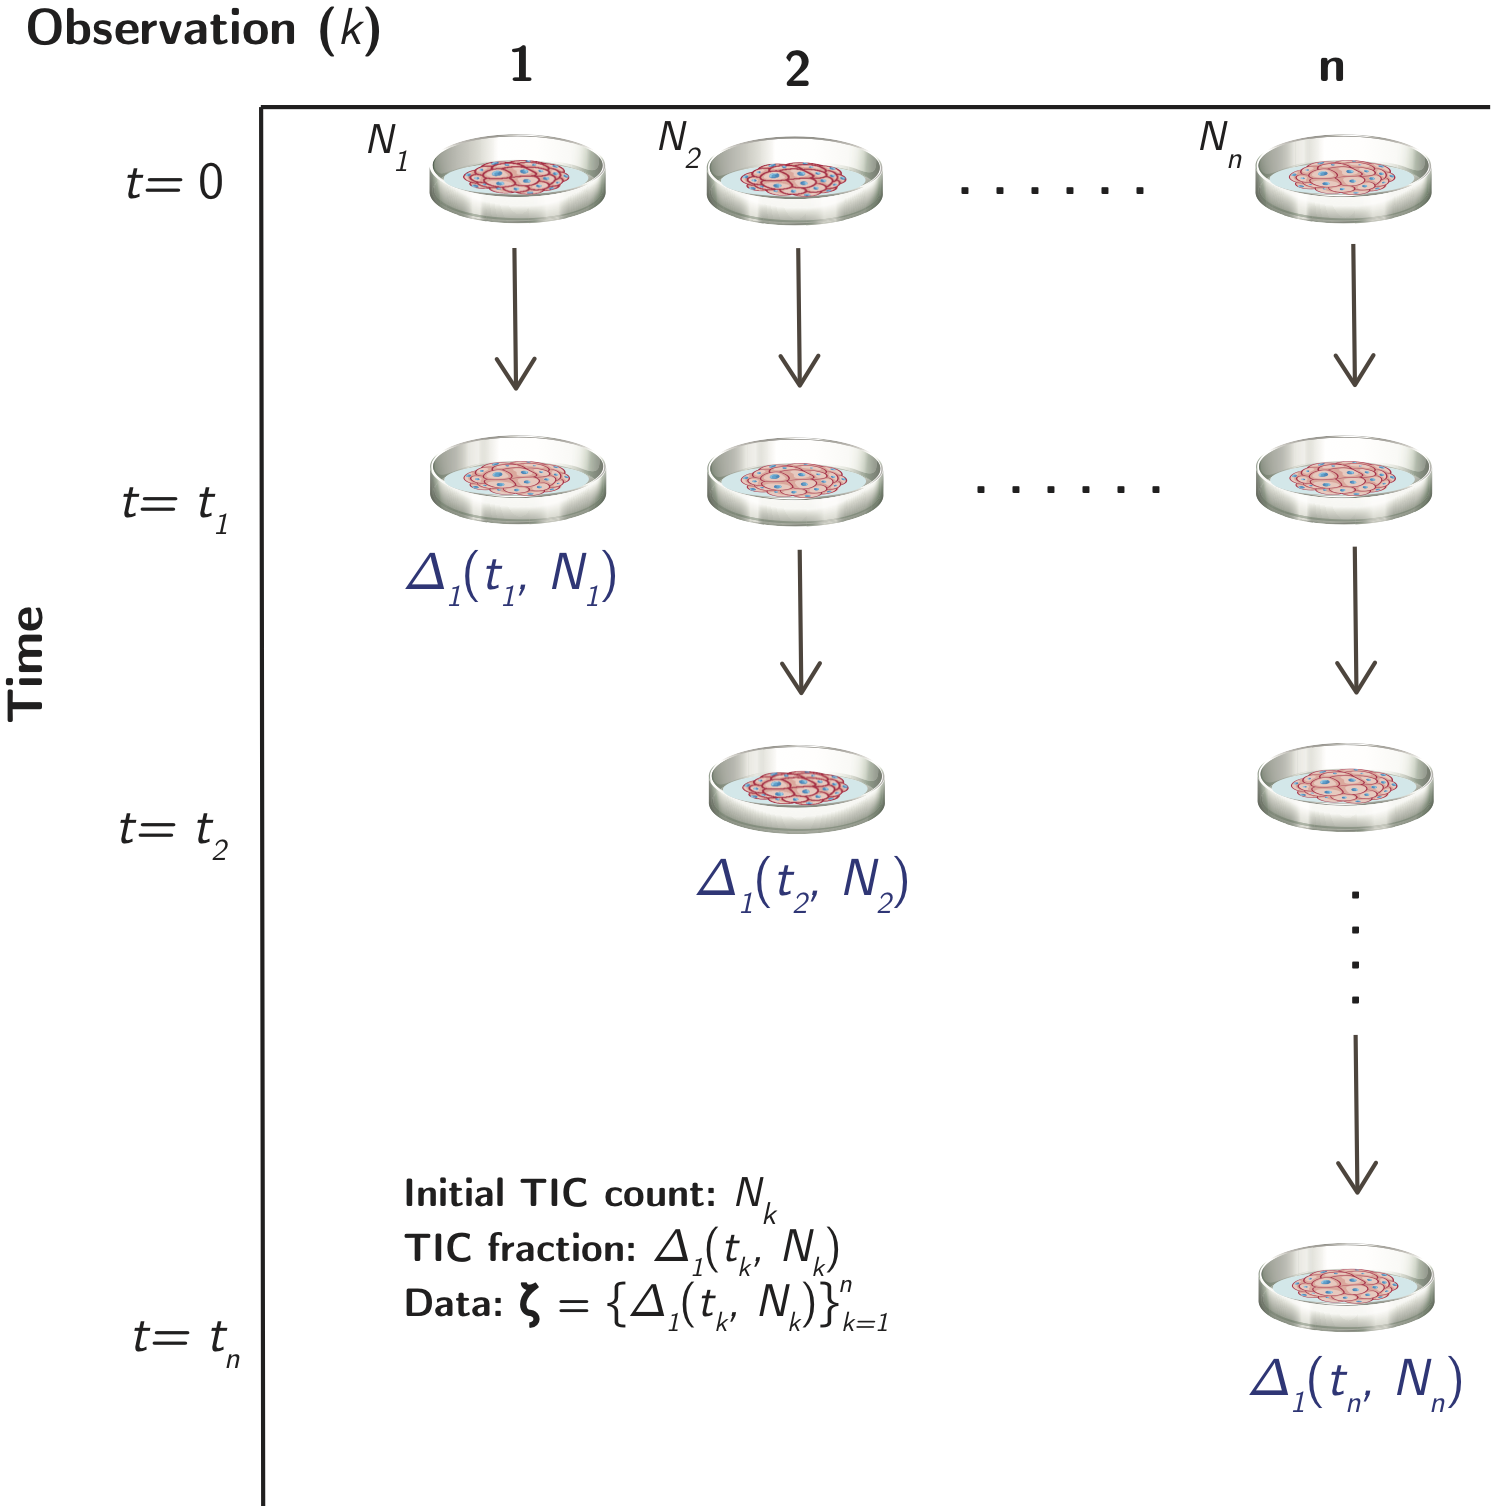

In [1]:
from IPython.display import Image
fig = Image(filename=('/Users/chinghao/Dropbox/CHW/Bayesian-TICinfer/notebooks/exp_protocol-eps-converted-to.png'))
fig

In [6]:
import numpy as np
#import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sys
import pickle
import os



%matplotlib inline

sns.set(style="white", font_scale = 2)
dir_name='./'
class bayesian_TIC_exp:
    
    def __init__(self, model_type = 'I', parameters = {'pvec': [0.0, 0.5, 0.5], 'N1': 100, 'T': 20, 'Nexp': 10}):
        
        # Total number of generations
        self.T = parameters['T'] 
        
        # Number of TICs at t = 0
        self.N1 = parameters['N1']
        
        # Growth parameter
        self.p = parameters['pvec']
        self.type = model_type
        
        
        # Number of observations
        self.Nexp = parameters['Nexp']
        
        
        # Initialization
        self.renew_exp()
        self.delta = []
        self.S2all = []
        self.pkall = []
        self.Nk = []
        self.Tk = []

    
        
        
        self.simulate()
        self.analyze_exp(True)
        #self.save_exp()

        


    def simulate(self):
        
        for i in range(self.Nexp):
            self.renew_exp()
            
            self.T_exp = self.T*(i+1)
            self.Tk = self.Tk + [self.T_exp]
            self.Nk = self.Nk + [self.pop[0]]
            
            for j in range(self.T_exp):
                self.grow_n_measure()
            
            
            
            self.delta = self.delta + [self.n1[-1]]
        
            
            
    def renew_exp(self):
        
        # Initial population [TICs, DCs]
       
        self.pop = [np.random.poisson(self.N1), 0]
        
        # Initial TIC fraction
        self.n1 = [1.0]
        self.n2 = [0.0]
        
        # Initial TIC numer
        self.z1 = [self.N1]
        self.z2 = [0]
        
        
        
        
    def grow_n_measure(self):
        
        
        if self.type == 'I':
            cycle = np.random.rand(self.pop[0])
            delta_pop = [(cycle < self.p[0]).sum(), ((cycle >= self.p[0]) & (cycle < self.p[0] + self.p[1])).sum(), ((cycle >= self.p[0] + self.p[1]) & (cycle < 1.0)).sum()]
            self.pop[0] = self.pop[0] - (delta_pop[0] + delta_pop[2]) + delta_pop[1]
            self.pop[1] = 2.0*delta_pop[2]
            self.z1.append(self.pop[0])
            self.z2.append(self.pop[1])
            self.n1.append(float(self.pop[0]/sum(self.pop)))
            self.n2.append(float(self.pop[1]/sum(self.pop)))
            self.pop[1] = 0
            
            
        elif self.type == 'II':
            cycle = np.random.rand(self.pop[0])
            cycle1 = np.random.rand(self.pop[1])
            p0 = 1.0 - self.p[0] # TIC dies
            p1 = self.p[0]*(1.0 -self.p[1]) # TIC self-renews
            delta_pop = [(cycle < p0).sum(), ((cycle >= p0) & (cycle < p0 + p1)).sum(), ((cycle >= p0 + p1) & (cycle < 1.0)).sum()]
            self.pop[0] = self.pop[0] - delta_pop[0] + delta_pop[1]
            
            delta_pop1 = [(cycle1 < 1.0-self.p[2]).sum(), ((cycle1 >= 1.0-self.p[2]) & (cycle1 < 1.0)).sum() ]
            self.pop[1] = self.pop[1] + delta_pop[2]  + delta_pop1[1] - delta_pop1[0]
            self.z1.append(self.pop[0])
            self.z2.append(self.pop[1])
            self.n1.append(float(self.pop[0]/sum(self.pop)))
            self.n2.append(float(self.pop[1]/sum(self.pop)))
            
                       
            

    def analyze_exp(self, c = False):

        if c == True:
            if self.type == 'I':
                n1, n2= (20, 20)
                p1 = np.linspace(0.1, 0.8, n1) # p1: renewal prob
                p2 = np.linspace(0.1, 0.8, n2) # p2: symmetric division
                p1v, p2v = np.meshgrid(p1, p2)
                lhd = np.zeros([n1,n2])


                for ix in range(n1):
                    for iy in range(n2):
                        self.q1 = p1[ix]
                        self.q2 = p2[iy]
                        self.compute_statistics_theory()
                        
                        lhd[ix,iy] = self.log_lhd
                self.lhd_all = lhd


                ind = np.unravel_index(np.argmax(lhd, axis=None), lhd.shape)
                xmax = [p1[ind[0]]]
                ymax = [p2[ind[1]]]
                st =  '(' + f"{p1[ind[0]]:.2f}" +', ' + f"{p2[ind[1]]:.2f}" + ')'

                
                # set up figure
                fig, ax = plt.subplots(figsize = (8,6))
                fs = 18 # font size
                fs_s = 12 # small text font size
                ms = 5 # marker size
                ms_s = 2
                lw = 3 # line width size

                plt.pcolormesh(p1v, p2v, np.transpose(lhd))
                plt.colorbar() #need a colorbar to show the intensity scale
                plt.scatter(xmax, ymax, s=100, facecolors='none', edgecolors='k')
                plt.scatter([self.p[1]], [self.p[2]], marker = '^', s=100, facecolors='none', edgecolors='b')
                plt.text(0.2, 0.2, r'$\theta_0 =($' + str(self.p[1]) + ', ' + f"{self.p[2]:.2f}" + r'$)$', color = 'b', fontsize=20)
                plt.text(0.4, 0.3, r'$\hat{\theta}_{MLE} =$' + st, color = 'k', fontsize=20)
                plt.title("MLE")
                plt.xlabel(r"self-renew, $p_1$")
                plt.ylabel(r"differentiate, $p_2$")
                plt.show() #boom
                
                file_str = 'EXP_' + self.type + '_T'+ str(self.T) + '_Nexp' + str(self.Nexp) + '_N0' + str(self.N1) + '_pvec' + str(self.p[0])  + '_' + str(self.p[1])+ '_' + str(self.p[2])
                title_str = 'MLE_' + file_str
                fig.savefig(title_str + '.pdf', bbox_inches='tight')
                
            
            elif self.type == 'II':
                n1, n2= (20, 20)
                p1 = np.linspace(0.5, 0.75, n1) # p: TIC survival
                p2 = np.linspace(0.5, 0.7, n2) # lambda: TIC asym differentiate
                p1v, p2v = np.meshgrid(p1, p2)
                lhd = np.zeros([n1,n2])

    
                for ix in range(n1):
                    for iy in range(n2):
                        self.q1 = p1[ix]
                        self.q2 = p2[iy]
                        self.q3 = self.p[2]
                        self.compute_statistics_theory()
                            
                        lhd[ix,iy] = self.log_lhd
                self.lhd_all = lhd
                    
                ind = np.unravel_index(np.argmax(lhd, axis=None), lhd.shape)
                xmax = [p1[ind[0]]]
                ymax = [p2[ind[1]]]
                st =  '(' + f"{p1[ind[0]]:.3f}" +', ' + f"{p2[ind[1]]:.3f}" + ')'
                

               # set up figure
                fig, ax = plt.subplots(figsize = (8,6))
                fs = 18 # font size
                fs_s = 12 # small text font size
                ms = 5 # marker size
                ms_s = 2
                lw = 3 # line width size

                plt.pcolormesh(p1v, p2v, np.transpose(lhd))
                plt.colorbar() #need a colorbar to show the intensity scale
                plt.scatter(xmax, ymax, s=100, facecolors='none', edgecolors='k')
                plt.scatter([self.p[0]], [self.p[1]], marker = '^', s=100, facecolors='none', edgecolors='b')
                plt.text(0.6, 0.62, r'$\theta_0 =($' + f"{self.p[0]:.2f}" + ', ' + f"{self.p[1]:.2f}" + r'$)$', color = 'b', fontsize=20)
                plt.text(0.6, 0.58, r'$\hat{\theta}_{MLE} =$' + st, color = 'k', fontsize=20)
                plt.title(r'MLE, $q = $' + str(self.p[2]))
                plt.xlabel(r"survive, $p$")
                plt.ylabel(r"differentiate, $\lambda$")
                plt.show() #boom
                
                file_str = 'EXP_' + self.type + '_T'+ str(self.T) + '_Nexp' + str(self.Nexp) + '_N0' + str(self.N1) + '_pvec' + str(self.p[0])  + '_' + str(self.p[1])+ '_' + str(self.p[2])
                title_str = 'MLE_' + file_str
                fig.savefig(title_str + '.pdf', bbox_inches='tight')

      


    def compute_statistics_theory(self):

        # this function computes the followings:
        #  s1 : number variance of z1
        #  s2 : number variance of z2
        #  cov: covariance Cov(z1, z2)
        #  pk1: mean fraction of z1
        #  pk2: mean fraction of z2
        #  S : variance of n1

       
        s1 = []
        s2 = []
        cov = []
        pk1 = []
        pk2 = []
        S = []
        M = []


        if self.type == 'I':
            x = 2.0*self.q1 # 2 times the self-renewal prob
            y = 2.0*self.q2 # 2 times the symmetric division prob
            
            for it in self.Tk:
                index = self.Tk.index(it)
                if x != 1.0:
                    s1 = s1 + [x**it *(x**it - 1.0)*2.0*(1-x/2.0)/(x-1.0)]
                    s2 = s2 + [(y**2)*(x**(it-1))*(1.0-(x**(it)))/ (1.0 -x) + y*(x**(it-1))]
                    cov = cov + [y*(x**it)*((1.0 - (x**(it-1)))/(1.0 -x)-(x**(it-1)))]
                else:
                    s1 = s1 + [x**it *it*2.0*(1.0-x/2.0)]
                    s2 = s2 + [(y**2)*(x**(it-1))*(it) + y*(x**(it-1))]
                    cov = cov + [y*(x**it)*(it-1-(x**(it-1)))]

                
                pk1 = pk1 + [x / (x+y)]
                pk2 = pk2 + [1.0-pk1[-1]]
                M = M + [(x**it) + y*(x**(it-1))]
                S  = S  + [ (s1[-1]*(1.0 - pk1[-1])**2 + s2[-1]*(pk1[-1]**2) - 2.0*cov[-1]*pk1[-1]*(1.0 - pk1[-1]))/self.Nk[index]/M[-1]/M[-1]]
            self.s1 = s1
            self.s2 = s2
            self.cov = cov
            self.pk1 = pk1
            self.pk2 = pk2
            self.S = S
            
            
        elif self.type == 'II':
            x = self.q1 # p
            y = self.q2 # lambda
            z = self.q3 # q

            for it in self.Tk:
                index = self.Tk.index(it)
                s1  = s1  + [(x**(it))*(2.0-y)**(it-1)*((2.0-y)*(1.0-(x*(2.0-y))**it) + 2.0*it*(1.0-y))]
                pk1 = pk1 + [(x*(2.0-y))**(it)*(2*z-x*(2-y)) /(2.0*(z-x)*(x*(2-y))**it + x*y*(2*z)**it)]
                b22t = 0.0
                
                for iit in range(1, it):
                    if 2*z == x*(2.0-y):
                        m12 = x*y*iit*(x*(2.0-y))**(iit-1)
                    else:
                        m12 = x*y*((2*z)**iit -(x*(2.0 - y))**iit)/(2*z - x*(2.0-y))

                    if 2*z == 1.0:
                        b22t += (m12*m12*2*x*(1.0-y) + (x*y*(2*z)**iit)*(2*m12+ iit))*(x*(2.0-y))**(it-1-iit)
                    else:
                        b22t += (m12*m12*2*x*(1.0-y) + (x*y*(2*z)**iit)*(2*m12+ (1.0-(2*z)**iit)/(1.0-2*z)))*(x*(2.0-y))**(it-1-iit)
                
                s2 = s2 + [b22t + (2*z)**it - (2*z)**(2*it)]

                
                if 2*z == x*(2.0-y) and 2*z == 1.0:
                    at = 1.0 + it-1.0
                elif 2*z == x*(2.0-y) and 2*z != 1.0:
                    at = 1.0 + 2*z*(1.0-(2*z)**(it-1))/ (1-2*z)
                elif 2*z == 1.0 and x*(2-y) != 1.0:
                    at = 1.0 + (2*z*(2*z-x*y)*(it-1) - 2*x*(1.0-y)*(x*(2.0-y))*(1.0 - (x*(2.0-y))**(it-1))/(1.0-x*(2-y))) /(2*z - x*(2.0-y))
                elif 2*z != 1.0 and x*(2-y) == 1.0:
                    at = 1.0 + (2*z*(2*z-x*y)*(1.0-(2*z)**(it-1))/(1.0-2.0*z) - 2*x*(1.0-y)*(x*(2.0-y))*(it-1)) /(2*z - x*(2-y))
                else:
                    at = 1.0 + (2*z*(2*z-x*y)*(1.0-(2*z)**(it-1))/(1.0-2.0*z) - 2*x*(1.0-y)*(x*(2.0-y))*(1.0 - (x*(2.0-y))**(it-1))/(1.0-x*(2.0-y))) /(2*z - x*(2-y))

                
                if 2*z == x*(2.0-y):
                    m12t = x*y*it*(x*(2.0-y))**(it-1)
                else:
                    m12t = x*y*((2*z)**it -(x*(2.0 - y))**it)/(2*z - x*(2.0-y))
                
                cov = cov + [at*y*(x**it)*(2.0 -y)**(it-1)-((x*(2.0-y))**it)*m12t]
                pk2 = pk2 + [1.0-pk1[-1]]
                M = M + [(x**it)*(2.0-y)**it + m12t]
                S  = S  + [(s1[-1]*(1.0 - pk1[-1])**2 + s2[-1]*(pk1[-1]**2) - 2.0*cov[-1]*pk1[-1]*(1.0 - pk1[-1]))/self.Nk[index]/M[-1]/M[-1]]

            
            self.s1 = s1
            self.s2 = s2
            self.pk1 = pk1
            self.cov = cov
            self.pk1 = pk1
            self.pk2 = pk2
            self.S = S
            

        tmp = 0.0
        for i in range(self.Nexp):
            tmp = tmp - np.log(self.S[i])/2.0 - ((self.delta[i]-self.pk1[i])**2)/self.S[i]/2.0
                
        self.log_lhd = tmp - self.Nexp*np.log(2.0*math.pi)/2.0
    
    def save_exp(self):
        
        file_name = 'EXP_T' + str(self.T) + '_Nexp' + str(self.Nexp) + '_N0' + str(self.N1) + '_pvec' + str(self.p[0])  + '_' + str(self.p[1])

        name = os.path.join(dir_name, file_name)
        pickle.dump( {'parameters':parameters, 'delta': self.delta, 'Tk': self.Tk, 'Nk': self.Nk, 'lhd': self.lhd_all}, open(name, 'wb'))
        


## Synthetic data of model B

Here we do MLE on model B. To do so, one needs to specify the **true model parameter** $\mathbf{p}=(p, \lambda, q)$, $N_1$, and $N_{exp}$. Note that the number of TICs in each of the $N_{exp}$ experiments is set to be $\text{Poisson} (N_1)$ to account for variations. The $\texttt{bayesian_TIC_exp}$ class generates synthetic data $\mathcal{D} =\{\Delta_1(t_1, N_1), \cdots, \Delta_1(t_{10}, N_{10})\}$, where $t_1 <t_2<\cdots <t_{10}$. The goal is to do MLE based on $\mathcal{D}$ to infer the true parameter.

The $\texttt{analyze_exp}$ attribute of this class analyze $\mathcal{D}$ using MLE procedure outlined above. Note that this step invokes $\texttt{compute_statistics_theory}$ attribute which computes the theoretically derived functions such as $\sigma_i(t)$, $p_i(t)$, $\Sigma_{12}(t), M(t)$ and $S^2(t)$ required to compute the log-likelihood. These expressions are provided in the note.

To facilitate visualization, I assume that the DC division rate ($q$) is know so that we're only doing two-parameter inference, $\boldsymbol{\theta}_0=(p, \lambda)$. The whole procedure is just one-liner (broken down into two lines for clarity) in the script below. The data is generated with $\mathbf{p}=(p, \lambda, q)= (0.7, 0.6, 0.5)$ on $N_{exp}=10$ experiments, each of which contains Poisson$(N_1=3000)$ TICs at the beginning. The gap between observations is set to 1 generation (can be arbitrary).

The colormap indicates the log-likelihood $L_n(\mathcal{D}|p,\lambda)$. MLE result is marked as $\hat{\boldsymbol{\theta}}_{MLE}$.

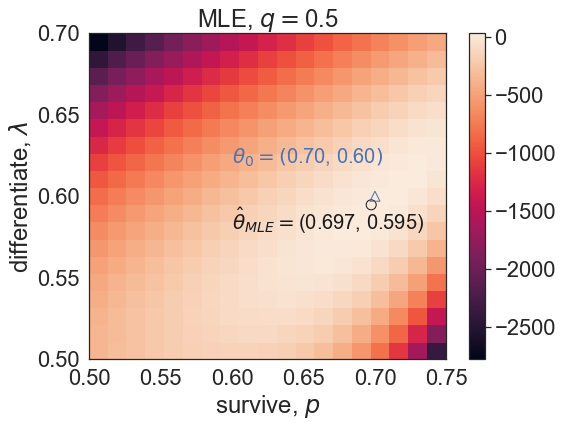

In [4]:
parameters = {'pvec': [0.7, 0.6, 0.5], 'N1': 3000, 'T': 1, 'Nexp': 10}

g = bayesian_TIC_exp(model_type = 'II', parameters = parameters)

## Synthetic data of model A

Here we do MLE on model B. To do so, one needs to specify the **true model parameter** $\mathbf{p}=(p_0, p_1, p_2)$, $N_1$, and $N_{exp}$. Note that the number of TICs in each of the $N_{exp}$ experiments is set to be $\text{Poisson} (N_1)$ to account for variations. The $\texttt{bayesian_TIC_exp}$ class generates synthetic data $\mathcal{D} =\{\Delta_1(t_1, N_1), \cdots, \Delta_1(t_{10}, N_{10})\}$, where $t_1 <t_2<\cdots <t_{10}$. The goal is to do MLE based on $\mathcal{D}$ to infer the true parameter.

The $\texttt{analyze_exp}$ attribute of this class analyze $\mathcal{D}$ using MLE procedure outlined above. Note that this step invokes $\texttt{compute_statistics_theory}$ attribute which computes the theoretically derived functions such as $\sigma_i(t)$, $p_i(t)$, $\Sigma_{12}(t), M(t)$ and $S^2(t)$ required to compute the log-likelihood. These expressions are provided in the note.

In this case, we're only doing two-parameter inference, $\boldsymbol{\theta}_0=(p_1, p_2)$ since $p_0=1-p_1-p_2$ by conservation of probability. The whole procedure is just one-liner (broken down into two lines for clarity) in the script below. The data is generated with $\mathbf{p}=(p_0, p_1, p_2)= (0.3, 0.5, 0.2)$ on $N_{exp}=70$ experiments, each of which contains Poisson$(N_1=200)$ TICs at the beginning. The gap between observations is set to 1 generation (can be arbitrary).

The colormap indicates the log-likelihood $L_n(\mathcal{D}|p_1,p_2)$. MLE result is marked as $\hat{\boldsymbol{\theta}}_{MLE}$.

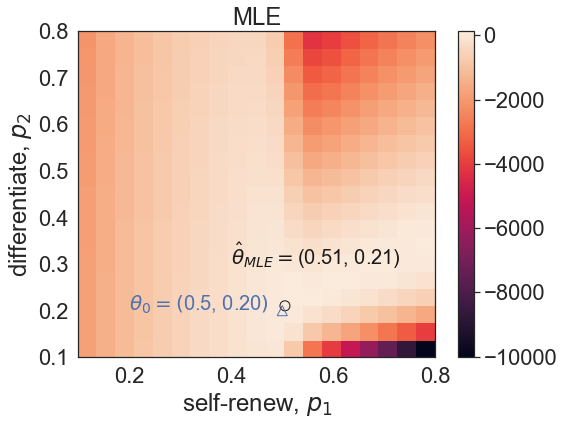

In [8]:
parameters = {'pvec': [0.3, 0.5, 0.2], 'N1': 200, 'T': 1, 'Nexp': 70}

g = bayesian_TIC_exp(model_type = 'I', parameters = parameters)